<a href="https://colab.research.google.com/github/rreghunandan/Customer-Personality-Analysis/blob/main/Customer_Personality_Ananlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime

# **Plotting Theme**

In [3]:
#set matplotlib parameters
mp.rc_file_defaults()
rc = {'axes.facecolor':'white','grid.color': '.8',}
plt.rcParams.update(rc)

#set seaborn color palette
sns.set_palette(sns.color_palette("RdPu", 6))
palette = ["#fcd7d3","#faabb8","#f667a0","#cd238e","#cd238e"]

# **Loading Data**

In [4]:
data = pd.read_csv("/content/marketing_campaign.csv", sep="\t")
print("Data loaded with", len(data), "rows")
data.head()

Data loaded with 2240 rows


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# **Data Cleaning**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Data Cleaning 
*Drop un-needed columns

*Drop rows with empty income values (These form a small percentage of data)

*Change the Dt_Customer to a DateTime format

In [6]:
#drop un-needed columns
data= data.drop(["ID","Z_CostContact", "Z_Revenue"], axis=1)
#drop rows with missing values
data= data.dropna()
#change date format
data["Dt_Customer"]= pd.to_datetime(data["Dt_Customer"])

EDA

In [7]:
#examining categorical data
print("Education Values: ", data["Education"].unique())
print("Marital_Status Values:", data["Marital_Status"].unique())

Education Values:  ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status Values: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [8]:
#give each feature a smaller set of values
edu= {"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"}
data["Education"]= data["Education"].replace(edu)

In [9]:
status= {"YOLO": "Single", "Absurd": "Single", "Alone": "Single", "Widow": "Single", "Divorced": "Single", "Together": "Taken", "Married": "Taken"}
data["Marital_Status"]= data["Marital_Status"].replace(status)


In [10]:
#new values
print("Education Values: ", data["Education"].unique())
print("Marital_Status Values:", data["Marital_Status"].unique())

Education Values:  ['Graduate' 'Postgraduate' 'Undergraduate']
Marital_Status Values: ['Single' 'Taken']


We can then transform some of the features as follows

In [11]:
#finding customer age
data["Age"]= datetime.now().year-data["Year_Birth"]

In [12]:
#finding family size and number of children
data["Children_Count"]= data["Kidhome"]+data["Teenhome"]
data["Family_Size"]= 1+data["Children_Count"]+data["Marital_Status"].replace({"Taken": 1, "Single": 0})

In [13]:
#finding number of days since person became a customer
data["Customer_For"]= (datetime.now()-data["Dt_Customer"]).dt.days

In [14]:
#finding total spendings of customer
data["Spendings"]= data["MntWines"]+data["MntFruits"]+data["MntFishProducts"]+data["MntMeatProducts"]+data["MntSweetProducts"]+data["MntGoldProds"]

In [15]:
#finding total number of purchases of customer
data["Purchases"]= data["NumDealsPurchases"]+data["NumWebPurchases"]+data["NumCatalogPurchases"]+data["NumStorePurchases"]

In [16]:
#finding total number of accepted campaigns
data["Accepted_Campaigns"]= data["AcceptedCmp1"]+data["AcceptedCmp2"]+data["AcceptedCmp3"]+data["AcceptedCmp4"]+data["AcceptedCmp5"]


In [17]:
#dropping un-needed columns
data= data.drop(["Year_Birth","Dt_Customer"],axis=1)

Outlier Removal

Now we need to check the distribution of values in the dataset to remove any outliers



In [18]:
#examine the boxplots of different features
features= ["Age", "Income", "Customer_For", "Spendings", "Purchases"]


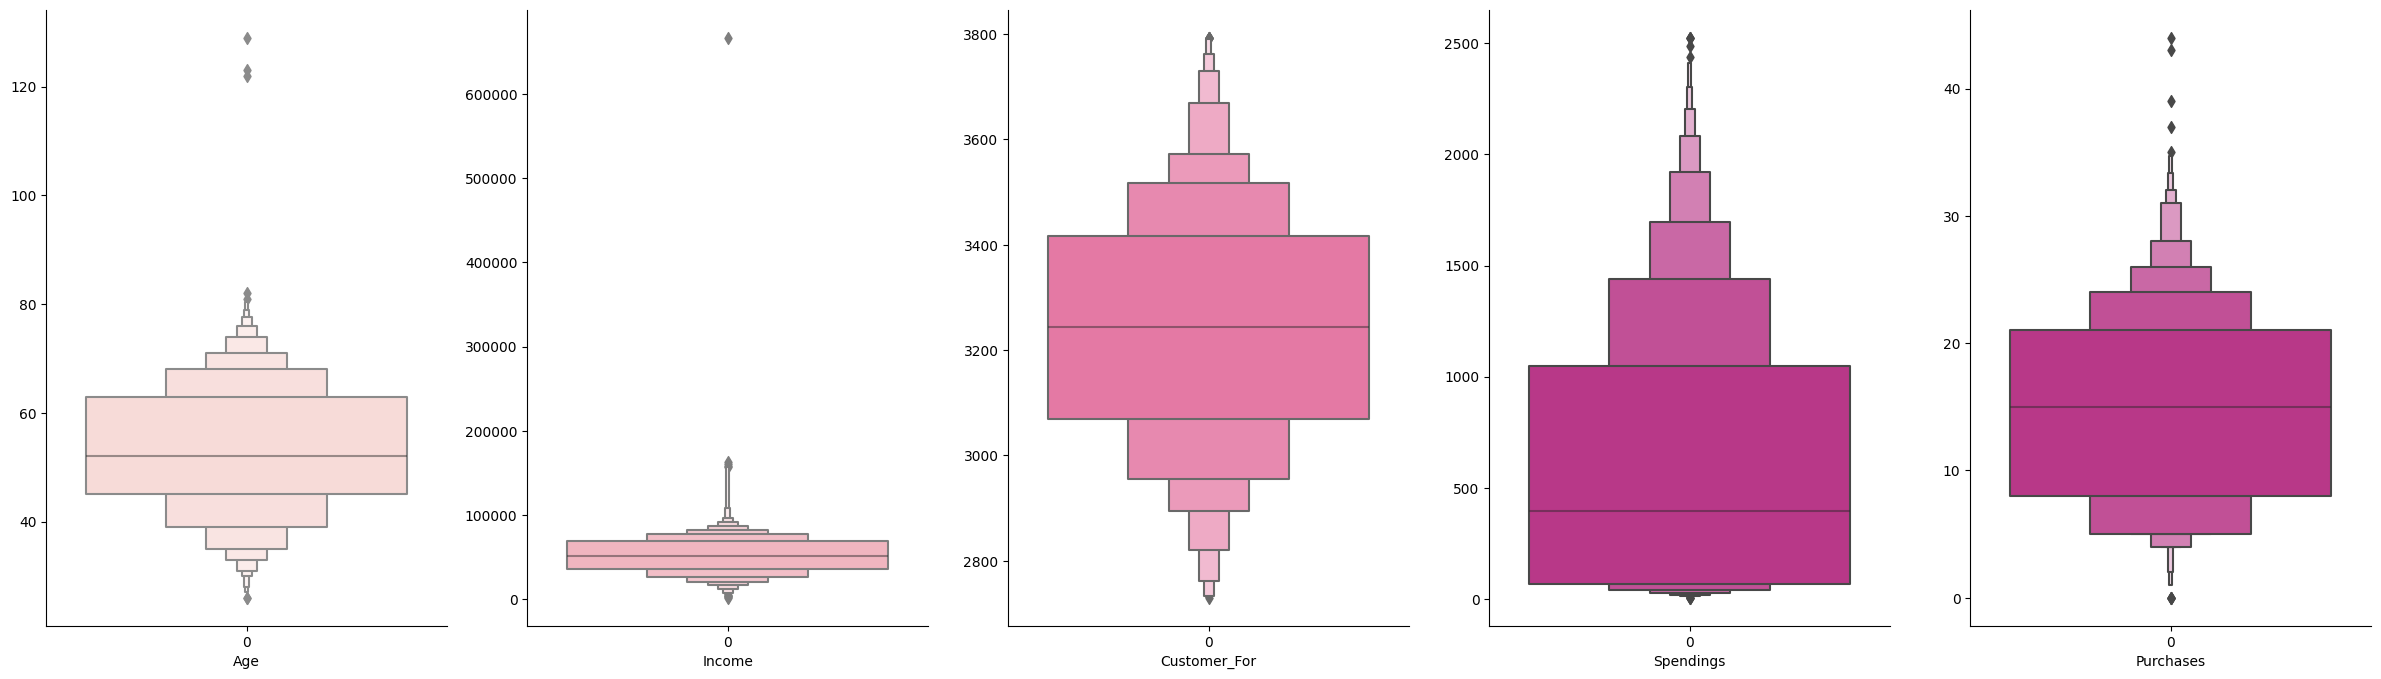

In [19]:
#create plots
fig, axs = plt.subplots(ncols=len(features),figsize=(6*len(features),8))
for i in range(len(features)):
  sns.boxenplot(data=data[features[i]],
                showfliers=True,
                ax=axs[i],
                palette=[palette[i]]
                ).set(xlabel=features[i])
  sns.despine()

In [20]:
#checking the number of outliers in age and income
print("Number of customers above the age of 100= ", len(data[data["Age"]>100]))
print("Number of customers with income above 200,000= ", len(data[data["Income"]>200000]))

Number of customers above the age of 100=  3
Number of customers with income above 200,000=  1


We can see some outliers in the age, income and purchases. Those in the age and income will be removed as they are very few data points. The ones in the purchases will be kept as the range of values is considerable

In [21]:
data= data.drop(data[(data["Age"]>100) | (data["Income"]>200000)].index)
print("Current data points count= ",len(data))

Current data points count=  2212


Taking a copy & dropping some features

In [22]:
dataCopy= data.copy()
data= data.drop(["Kidhome","Teenhome"],axis=1)

Encoding Categorical Features

The 2 categorial features we have can be encoded as follows:

Education: using a label encoder since it's considered ordinal

Marital_Status: using one hot encoding since it's considered nominal

In [23]:
#label encode education
encoder= LabelEncoder()
data["Education"]= data[["Education"]].apply(encoder.fit_transform)

#hot encode marital_status
data = pd.get_dummies(data)

#check data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Education              2212 non-null   int64  
 1   Income                 2212 non-null   float64
 2   Recency                2212 non-null   int64  
 3   MntWines               2212 non-null   int64  
 4   MntFruits              2212 non-null   int64  
 5   MntMeatProducts        2212 non-null   int64  
 6   MntFishProducts        2212 non-null   int64  
 7   MntSweetProducts       2212 non-null   int64  
 8   MntGoldProds           2212 non-null   int64  
 9   NumDealsPurchases      2212 non-null   int64  
 10  NumWebPurchases        2212 non-null   int64  
 11  NumCatalogPurchases    2212 non-null   int64  
 12  NumStorePurchases      2212 non-null   int64  
 13  NumWebVisitsMonth      2212 non-null   int64  
 14  AcceptedCmp3           2212 non-null   int64  
 15  Acce

Feature Scaling

In [24]:
#scale features
scaler= StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

#check
data.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Response,Age,Children_Count,Family_Size,Customer_For,Spendings,Purchases,Accepted_Campaigns,Marital_Status_Single,Marital_Status_Taken
0,-0.893586,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,...,2.375425,1.018352,-1.264598,-1.758359,1.973583,1.676245,1.317945,-0.43916,1.349603,-1.349603
1,-0.893586,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,...,-0.420977,1.274785,1.404572,0.449070,-1.665144,-0.963297,-1.159273,-0.43916,1.349603,-1.349603
2,-0.893586,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,...,-0.420977,0.334530,-1.264598,-0.654644,-0.172664,0.280110,0.796425,-0.43916,-0.740959,0.740959
3,-0.893586,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,...,-0.420977,-1.289547,0.069987,0.449070,-1.923210,-0.920135,-0.898513,-0.43916,-0.740959,0.740959
4,0.571657,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,...,-0.420977,-1.033114,0.069987,0.449070,-0.822130,-0.307562,0.535666,-0.43916,-0.740959,0.740959


# Dimensionality Reduction

let's take a look on the coorelation between features

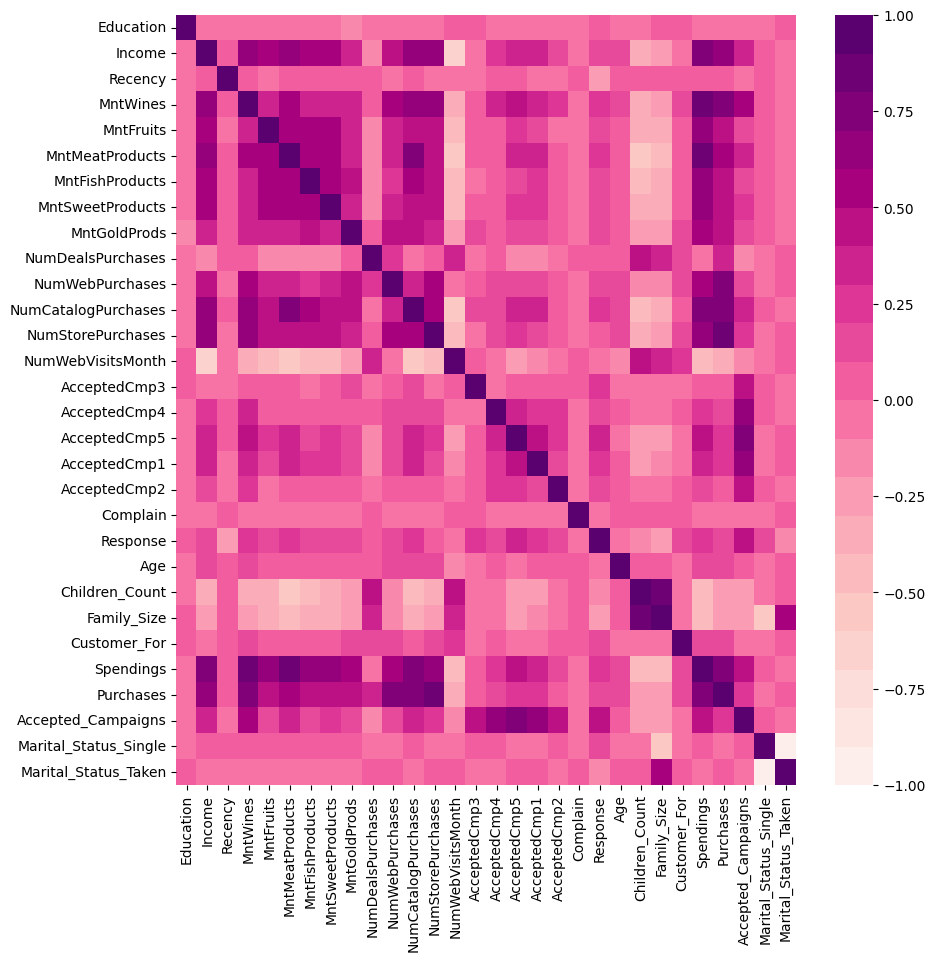

In [27]:
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(data.corr(),
            # cmap="YlGnBu",
            cmap= sns.color_palette("RdPu", 20),
            ax=ax)

A lot of features have high correlation values. PCA will be used to reduce the dimensions while keeping 95% of the variations

In [28]:
#95% variations
pca = PCA(n_components = 0.95)
pca.fit(data)
reduced_data = pd.DataFrame(pca.transform(data))

print("Current number of features= ",len(reduced_data.columns))

Current number of features=  20


By keeping 95% of the variations, the number of features dropped from 32 to 20, but we want to reduce that even more to reduce complexity, so we will compromise more variations.

In [29]:
#75% variations
pca = PCA(n_components = 0.75)
pca.fit(data)
reduced_data = pd.DataFrame(pca.transform(data))

print("Current number of features= ",len(reduced_data.columns))

Current number of features=  10


Data Clustering 

First, we need to have a good sense of how many clusters are in our dataset. To determine this, we will use the elbow method.

In [30]:
#calculate distortions for different values of k (number of clusters)
distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(reduced_data)
    distortions.append(kmeanModel.inertia_)

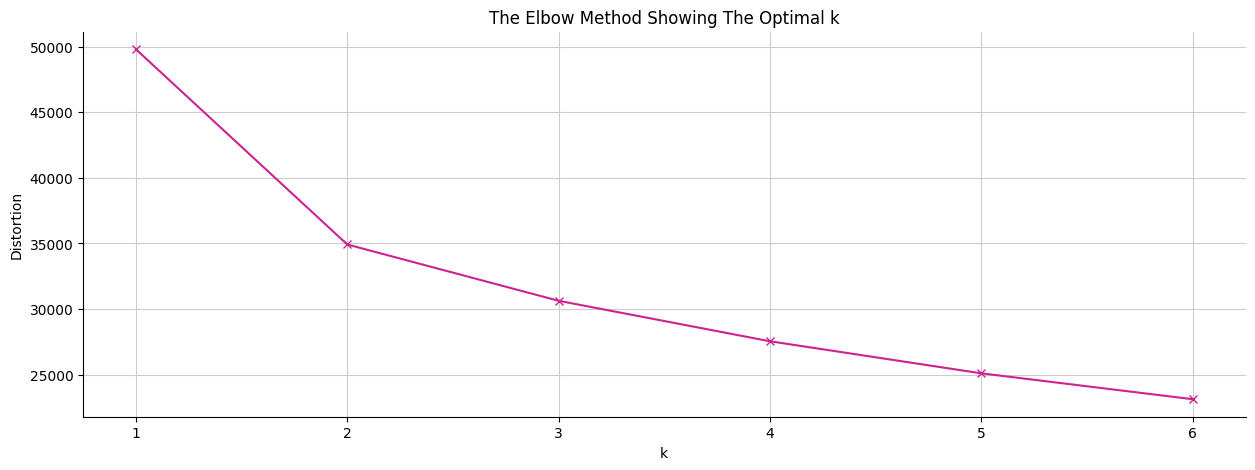

In [31]:
#plot elbow graph
plt.figure(figsize=(15,5))
plt.rcParams.update({'axes.grid': True})
plt.plot(K, distortions, 'bx-', color=palette[-1])
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing The Optimal k')
sns.despine()
plt.show()

Using the above plot, we will choose the value of k to be 4.



Clustering Algorithm

In [32]:
#clustering data and adding the output to the data dataframe
clusters = KMeans(n_clusters=4, random_state=202).fit(reduced_data)
data["Personality"]= clusters.labels_
dataCopy["Personality"]= clusters.labels_

data.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Age,Children_Count,Family_Size,Customer_For,Spendings,Purchases,Accepted_Campaigns,Marital_Status_Single,Marital_Status_Taken,Personality
0,-0.893586,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,...,1.018352,-1.264598,-1.758359,1.973583,1.676245,1.317945,-0.43916,1.349603,-1.349603,1
1,-0.893586,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,...,1.274785,1.404572,0.449070,-1.665144,-0.963297,-1.159273,-0.43916,1.349603,-1.349603,0
2,-0.893586,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,...,0.334530,-1.264598,-0.654644,-0.172664,0.280110,0.796425,-0.43916,-0.740959,0.740959,1
3,-0.893586,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,...,-1.289547,0.069987,0.449070,-1.923210,-0.920135,-0.898513,-0.43916,-0.740959,0.740959,0
4,0.571657,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,...,-1.033114,0.069987,0.449070,-0.822130,-0.307562,0.535666,-0.43916,-0.740959,0.740959,2


To get a sense of whether our clustering algorithm provides reasonable results, we can look at the pie and bar plots of the clusters to see how they're distributed.

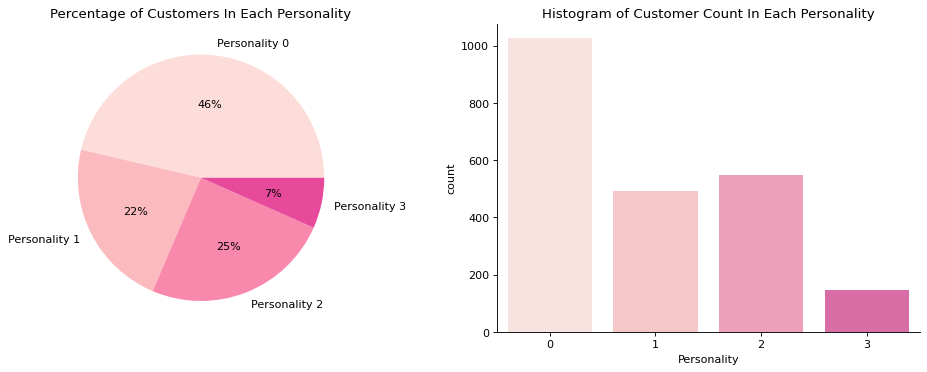

In [33]:
#define labels
labels = ['Personality 0', 'Personality 1', 'Personality 2', 'Personality 3']
counts= []

#compute counts
for i in range(4):
  counts.append(len(data[data["Personality"]==i]))

plt.figure(figsize=(15, 5), dpi=80)
plt.rcParams.update({'axes.grid': False})

#pie plot
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.set_title("Percentage of Customers In Each Personality")
plt.pie(counts, labels = labels, autopct='%.0f%%')

#bar plot
ax1 = plt.subplot2grid((1,2), (0, 1))
ax1.set_title("Histogram of Customer Count In Each Personality")
sns.countplot(x=data["Personality"], alpha=.9, ax=ax1)
sns.despine()

plt.show()


From the bar plot, we can see that the data seem to be sampled from a normal distribution, which makes sense since this is a customer segmentation problem.

Data Analysis

to find out the special characteristics of each cluster. To do that, we'll study their demographics and behaviors against different features.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


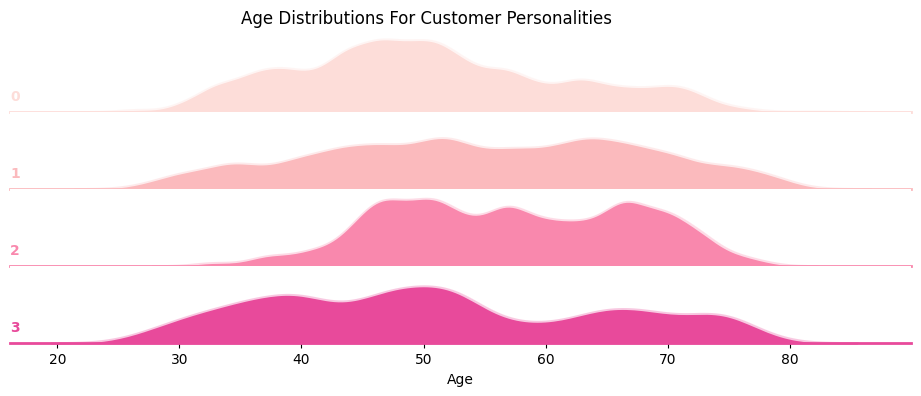

In [34]:
# Initialize the FacetGrid object
g = sns.FacetGrid(dataCopy,
                  row="Personality",
                  hue="Personality",
                  size= 1, aspect=10,
                  # palette=palette
                  )

# Draw the densities in a few steps
g.map(sns.kdeplot, "Age",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Age", clip_on=False, color="w", lw=2, bw_adjust=.5,alpha=.7)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(Age, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Age")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0.01)

# Remove axes details that don't play well with overlap
g.fig.suptitle('Age Distributions For Customer Personalities')
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


Conclusion:

Personalities 0 & 3: Have more young people than old people

Personality 1: Has a wide and nearly even distribution, which show a diverse variation in age groups.

Personality 2: mainly consists of older people compared to other personalities

In [35]:
#personality 0 age stats
d= dataCopy[dataCopy["Personality"]==0]
perc= (len(d[d["Age"]<60])/len(d))*100
print("Percentage of customer below 60 in personality 0= {:.2f}% ".format(perc))

#personality 1 age stats
d= dataCopy[dataCopy["Personality"]==1]
perc= (len(d[d["Age"]<55])/len(d))*100
print("Percentage of customer below 55 in personality 1= {:.2f}% ".format(perc))

#personality 2 age stats
d= dataCopy[dataCopy["Personality"]==2]
perc= (len(d[d["Age"]>50])/len(d))*100
print("Percentage of customer above 50 in personality 2= {:.2f}% ".format(perc))

#personality 3 age stats
d= dataCopy[dataCopy["Personality"]==3]
perc= (len(d[d["Age"]<60])/len(d))*100
print("Percentage of customer below 60 in personality 3= {:.2f}% ".format(perc))

Percentage of customer below 60 in personality 0= 78.54% 
Percentage of customer below 55 in personality 1= 50.00% 
Percentage of customer above 50 in personality 2= 70.07% 
Percentage of customer below 60 in personality 3= 70.75% 


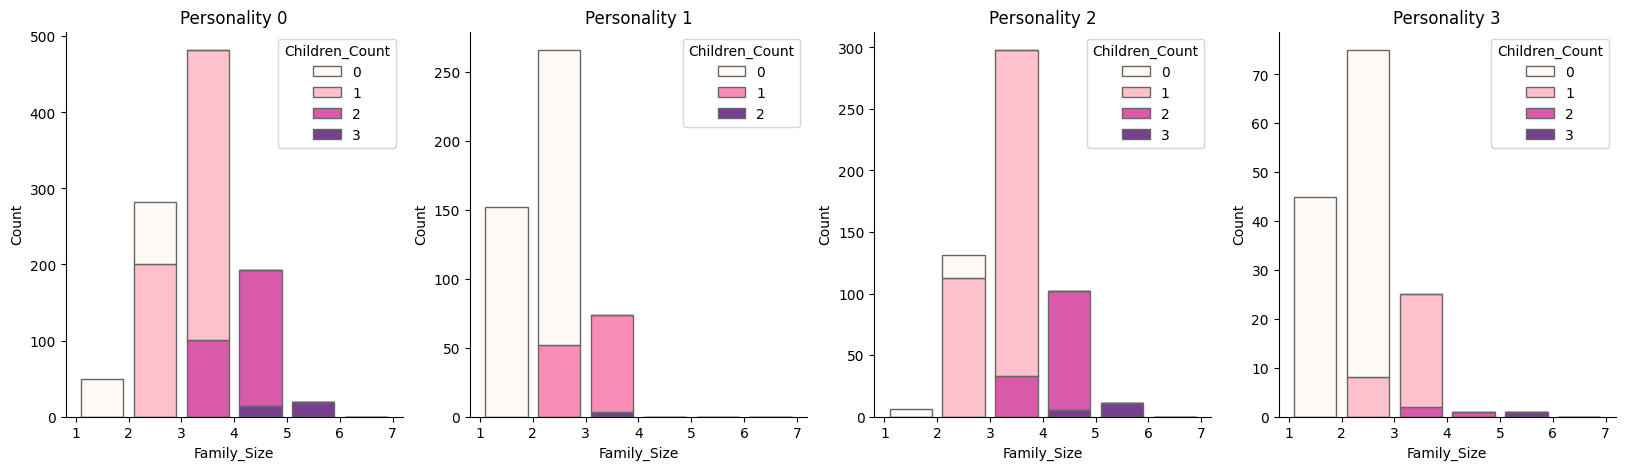

In [36]:
plt.figure(figsize=(20, 5))

#plotting a histogram of family size showing children count in each bin
for i in range(4):
  ax1 = plt.subplot2grid((1,4),(0,i))
  ax1.set_title("Personality "+str(i))
  sns.histplot(
      dataCopy[dataCopy["Personality"]==i],
      x="Family_Size",
      hue="Children_Count",
      multiple="stack",
      palette="RdPu",
      edgecolor=".4",
      bins= list(range(1,8)),
      shrink= .8
  )
  sns.despine()

Conclusion:

1.Personality 0:
The majority of customers have 1-2 kids and a partner.
A considerable percentage are single parents.

2.Personality 1:
The majority of customers have no kids (or 1 at most).
Almost equal numbers of single and non-single customers.
A considerable percentage are living alone.
Very few single parents.
Max family size is 3, which is fewer than the other segments.

3.Personality 2:
The majority of customers have 1-2 kids and a partner.
Relatively fewer single parents.

4.Personality 3:
The vast majority have 0 kids, followed by 1 kid.
A considerable percentage are living alone.
Very few single parents.

In [37]:
#personality 0 kids stats
d= dataCopy[dataCopy["Personality"]==0]
perc= ((len(d[d["Children_Count"]==1]) + len(d[d["Children_Count"]==2]))/len(d))*100
print("Percentage of customers having 1-2 kids in personality 0 = {:.2f}% ".format(perc))

#personality 1 kids stats
d= dataCopy[dataCopy["Personality"]==1]
perc= ((len(d[d["Children_Count"]==0]))/len(d))*100
print("Percentage of customers having 0 kids in personality 1 = {:.2f}% ".format(perc))

#personality 2 kids stats
d= dataCopy[dataCopy["Personality"]==2]
perc= ((len(d[d["Children_Count"]==1]) + len(d[d["Children_Count"]==2]))/len(d))*100
print("Percentage of customers having 1-2 kids in personality 2 = {:.2f}% ".format(perc))

#personality 3 kids stats
d= dataCopy[dataCopy["Personality"]==3]
perc= ((len(d[d["Children_Count"]==0]))/len(d))*100
print("Percentage of customers having 0 kids in personality 3 = {:.2f}% ".format(perc))

Percentage of customers having 1-2 kids in personality 0 = 84.10% 
Percentage of customers having 0 kids in personality 1 = 74.39% 
Percentage of customers having 1-2 kids in personality 2 = 92.70% 
Percentage of customers having 0 kids in personality 3 = 76.19% 


In [38]:
#single parents in personality 0
d= dataCopy[dataCopy["Personality"]==0]
perc= (len(d[d["Marital_Status"]=="Single"])/len(dataCopy[dataCopy["Marital_Status"]=="Single"]))*100
print("Percentage of single parents belonging to personality 0= {:.2f}% ".format(perc))

Percentage of single parents belonging to personality 0= 46.56% 


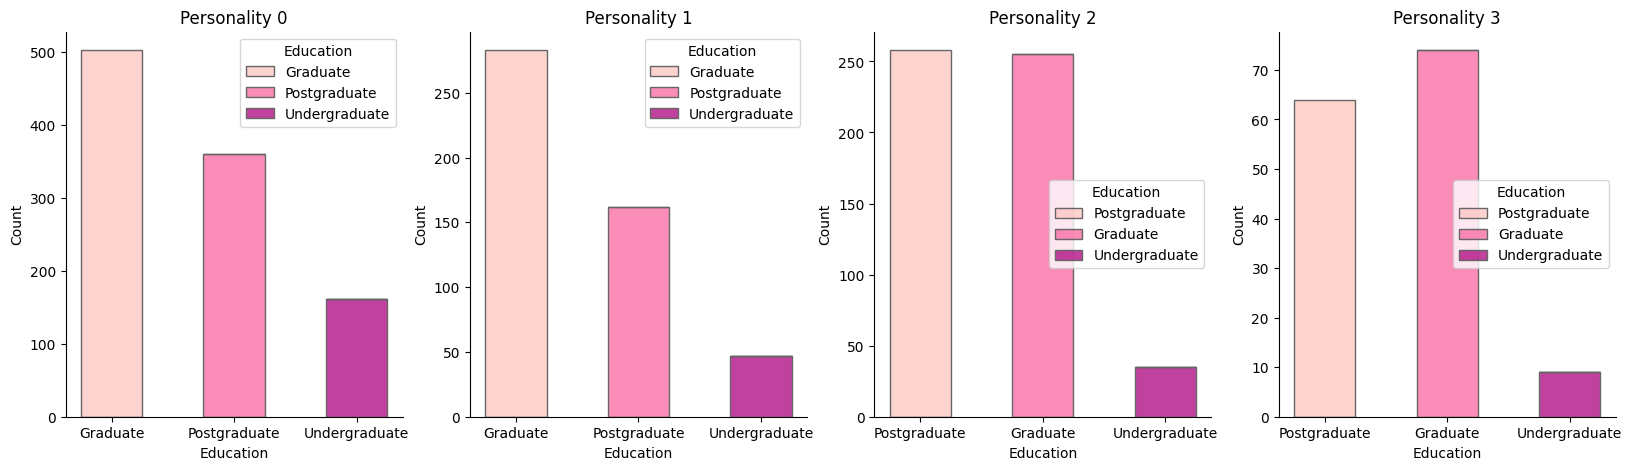

In [39]:
plt.figure(figsize=(20, 5))

#plotting a histogram of family size showing children count in each bin
for i in range(4):
  ax1 = plt.subplot2grid((1,4),(0,i))
  ax1.set_title("Personality "+str(i))
  sns.histplot(
      dataCopy[dataCopy["Personality"]==i],
      x="Education",
      hue= "Education",
      multiple="stack",
      palette="RdPu",
      edgecolor=".4",
      shrink= .5
  )
  sns.despine()

Conclusion:

Personality 0 has the largest percentage of undergraduates.

Personalities 2 & 3 have very similar education distributions.

The education distributions don't really help in differentiating between the different segments.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


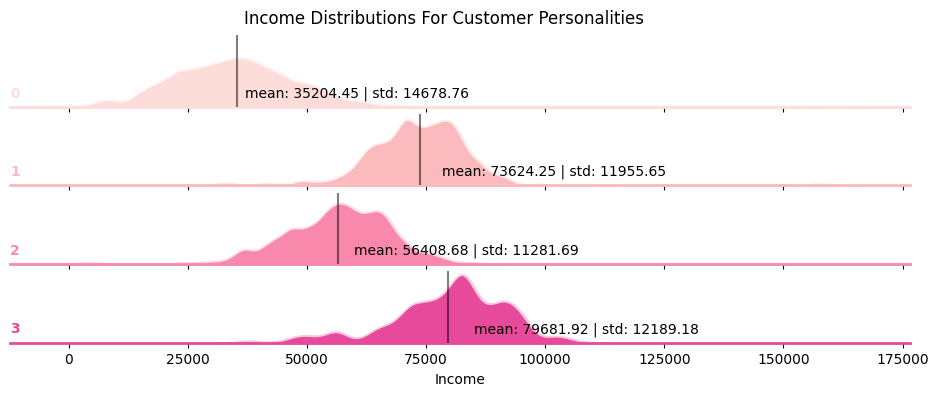

In [40]:
# Initialize the FacetGrid object
g = sns.FacetGrid(dataCopy,
                  row="Personality",
                  hue="Personality",
                  size= 1, aspect=10,
                  # palette=palette
                  )

# Draw the densities in a few steps
g.map(sns.kdeplot, "Income",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Income", clip_on=False, color="w", lw=2, bw_adjust=.5, alpha=.7)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(Income, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Income")

# Add vertical lines for mean age on each plot
def vertical_mean_line_survived(x, **kwargs):
    plt.axvline(x.mean(), linestyle ="-", 
                color = "black", alpha=.5)
    txkw = dict(size=10, color = "black")
    tx = "mean: {:.2f} | std: {:.2f}".format(x.mean(),x.std())
    ax = plt.gca()
    ax.text(0.06+x.mean()/175000, .2, tx, color="black", size= 10,
            ha="left", va="center", transform=ax.transAxes)
    # plt.text(x.mean()+1, 0.0052, tx, **txkw)

g.map(vertical_mean_line_survived, 'Income')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0.1)

# Remove axes details that don't play well with overlap
g.fig.suptitle('Income Distributions For Customer Personalities')
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Conclusion:

Personality 0 (Low):
Lowest average income group
Highest variation in income

Personality 1 (High):
Relatively higher average income group
Average variation in income

Personality 2 (Average):
Average income group
Average variation in income

Personality 3 (High):
Highest average income group
Similar to personality 1 group with slightly more variance


We will use a simple pie chart to visualize the types of products frequently bought by the customers.

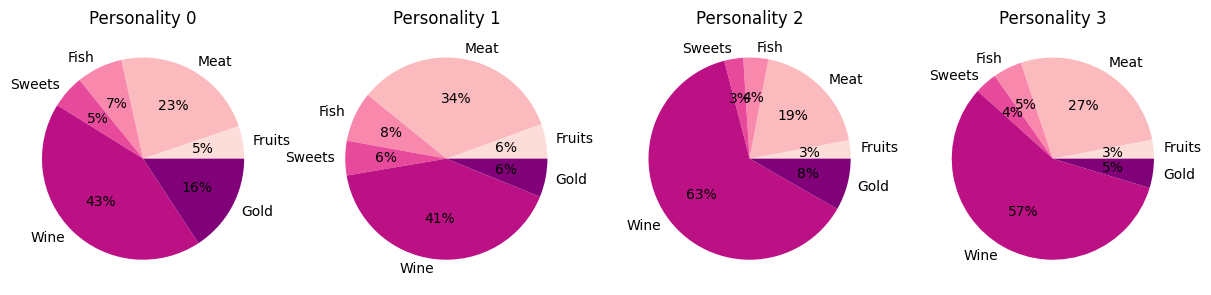

In [41]:
#define labels
labels = ['Fruits', 'Meat', 'Fish', 'Sweets', 'Wine', 'Gold']
plt.figure(figsize=(15, 10), dpi=100)

#compute counts
for i in range(4):
  counts= []
  #getting the data of the current segment
  d= dataCopy[dataCopy["Personality"]==i]

  #computing counts
  counts.append(d["MntFruits"].sum())
  counts.append(d["MntMeatProducts"].sum())
  counts.append(d["MntFishProducts"].sum())
  counts.append(d["MntSweetProducts"].sum())
  counts.append(d["MntWines"].sum())
  counts.append(d["MntGoldProds"].sum())

  #plotting chart
  ax1 = plt.subplot2grid((1,4),(0,i))
  ax1.set_title("Personality "+str(i))
  plt.pie(counts, labels = labels, autopct='%.0f%%')

plt.show()


From the above plots, we can see that:

The percentage of spendings on primary goods such as fruits, fish and sweets is very close across all segments.

Spendings on meat vary across segments.

Personality 0 spends relatively more on gold compared to other segments.

Personality 2 spends the most on wine.

<Figure size 400x400 with 0 Axes>

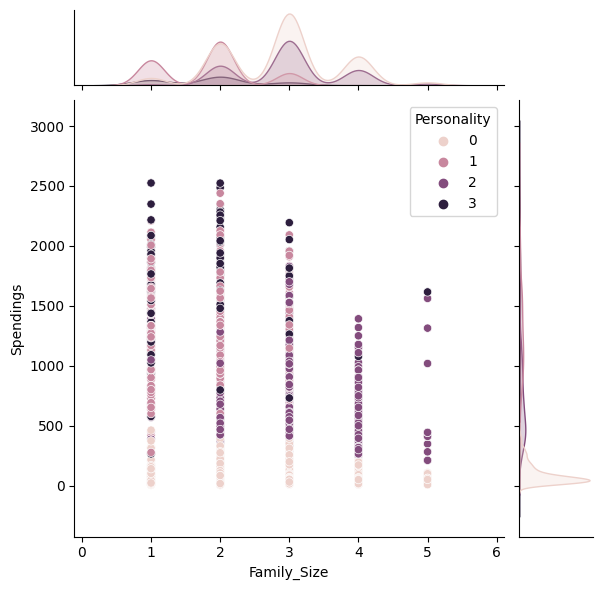

In [44]:
plt.figure(figsize=(5, 5), dpi=80)
g = sns.jointplot(data=dataCopy, x="Family_Size", y="Spendings", hue="Personality",kind="scatter")
sns.despine()

Finally, we will examine the customer's reactions to the company's campaigns in terms of how many campaigns have they accepted.

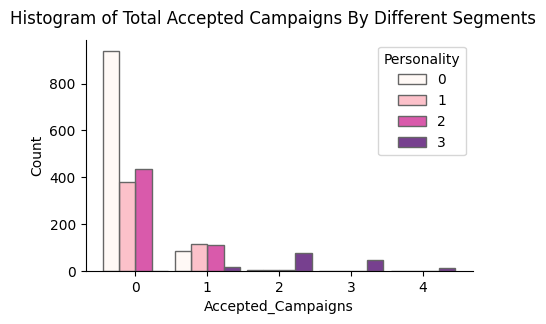

In [45]:
f= plt.figure(figsize=(5, 3))
f.suptitle("Histogram of Total Accepted Campaigns By Different Segments")
sns.histplot(dataCopy, x="Accepted_Campaigns", hue= "Personality", multiple="dodge", palette="RdPu", edgecolor=".4", discrete= True, shrink= .9)
sns.despine()

Conclusion:

Personalities 0, 1 & 2: Majority accepted 0 campaigns. Very few accepted only 1.

Personality 3: Majority accepted 2 campaigns. Some accepted 3 or 4. Very few accepted only 1. No one accepted 0 campaigns.

# Conclusion

CLuster 0: It contains customers who are below 60 having 1-2 kids(single parents included);low income & spending.

Cluster 1:It has customers who are below 55yrs and have no kids;Higher income & spending 

Cluster 2:Customers are below 50yrs have 1-2kids;Avg income

CLuster 3:Cutomers are below 60yrs ,have no kids ;High income & spending 
